In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from mpl_toolkits.mplot3d import Axes3D

### preliminary


In [3]:
x=[0,1,2,3]
kx=np.fft.fft(x)
print(x, kx)

[0, 1, 2, 3] [ 6.+0.j -2.+2.j -2.+0.j -2.-2.j]


### constant delta on the grid transform

In [4]:
x = np.linspace(-1,1,10)
y = np.linspace(-1,1,10)
z = np.linspace(-1,1,10)

spacing = x[1]-x[0]

X, Y, Z = np.meshgrid(x, y, z)

vol = len(x)*len(y)*len(z)
print(spacing)
print(vol)

0.2222222222222222
1000


Text(0.5, 0.92, 'congifuration space')

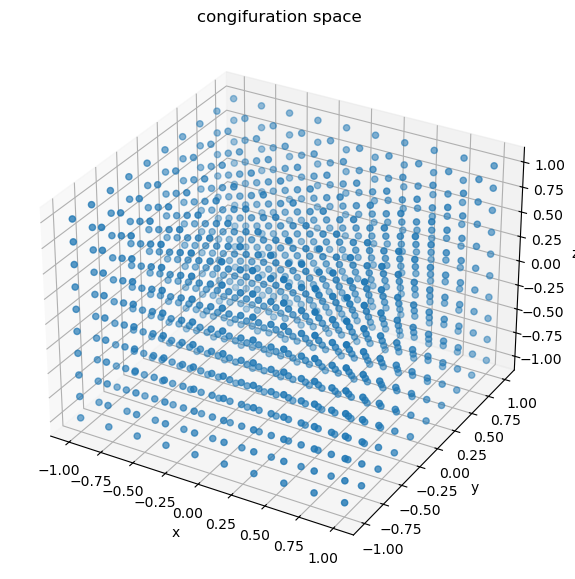

In [5]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('congifuration space')

In [6]:
grid = np.array([X,Y,Z])
print(grid.shape)

(3, 10, 10, 10)


In [7]:
kx = np.fft.fftfreq(len(x), spacing)
ky = np.fft.fftfreq(len(y), spacing)
kz = np.fft.fftfreq(len(z), spacing)

print(kx.shape, ky.shape, kz.shape)

kxs, kys, kzs = np.meshgrid(kx,ky,kz, indexing='ij')

print(kxs.shape, kys.shape, kzs.shape)

(10,) (10,) (10,)
(10, 10, 10) (10, 10, 10) (10, 10, 10)


Text(0.5, 0.92, 'fourier space')

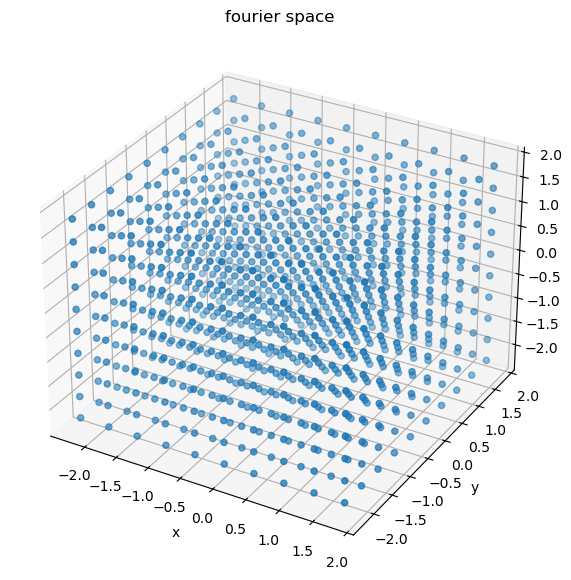

In [8]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kxs,kys,kzs)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('fourier space')

(10, 10, 10)


Text(0.5, 0.92, 'delta in config space')

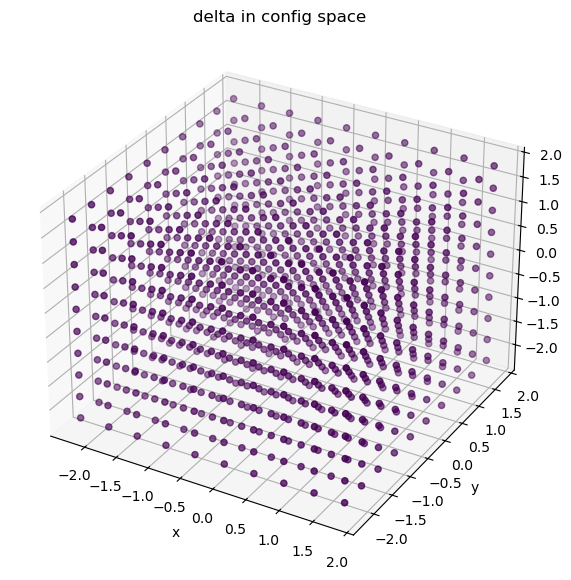

In [9]:
## define a constant overdensity field on the grid
delta = np.full_like(X, 3)
print(delta.shape)

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kxs,kys,kzs, c=delta)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('delta in config space')

(10, 10, 10)


/Users/edoardo/miniconda3/envs/acc-env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:4458: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


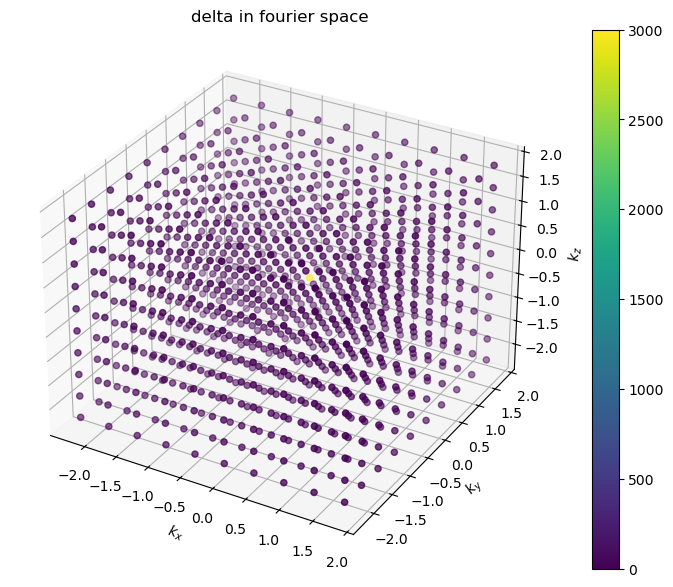

In [10]:
delta_transform = np.fft.fftn(delta)
print(delta.shape)

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(kxs,kys,kzs, c=delta_transform)
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')
ax.set_title('delta in fourier space')

plt.colorbar(scp)

Remember that $\mathcal{F}[const]=\delta_D (0)$: $\delta(k)$ is zero everywhere except in the origin

In [11]:
## computing P(k)=delta delta
Pk = 1./vol * np.array(np.abs(delta_transform))**2
print(Pk.shape)

(10, 10, 10)


In [12]:
print(np.max(Pk))

9000.0


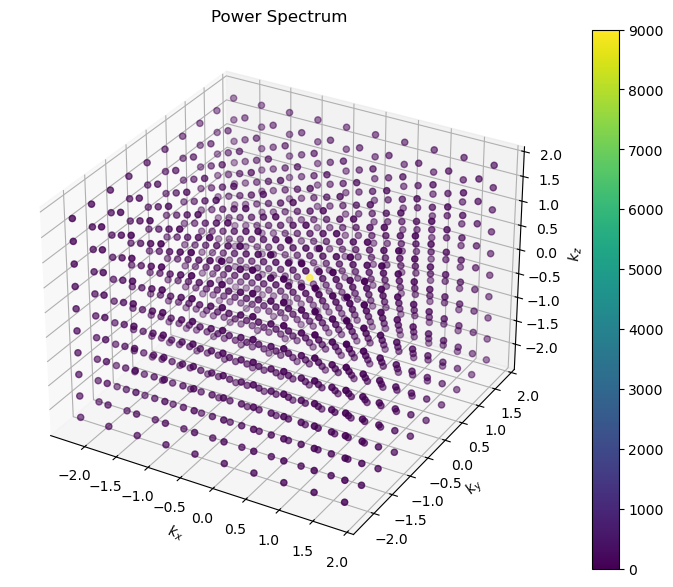

In [13]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(kxs,kys,kzs, c=Pk)
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')
ax.set_title('Power Spectrum')
plt.colorbar(scp)

In [14]:
## computing norm of the wavevectors

k_norm = np.sqrt(kxs**2+kys**2+kzs**2)
print(k_norm.shape)
print(k_norm.max())

(10, 10, 10)
3.897114317029974


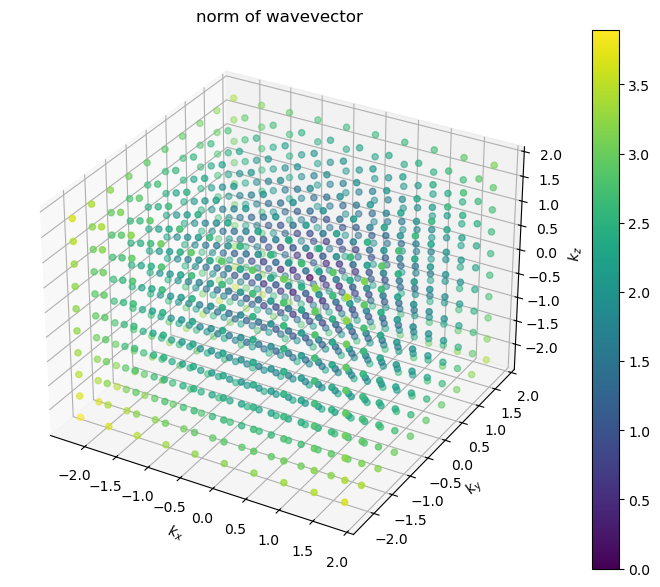

In [15]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(kxs,kys,kzs, c=k_norm)
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')
ax.set_title('norm of wavevector')
plt.colorbar(scp)

Now I need to bin P(k): consider bins with the same abs(k) within a certain range and average P(k) in these bins

In [16]:
kN = 2 * np.pi / spacing              # max frequency based on spacing
kF = 2 * np.pi / len(x)               # min frequency based on side length

print(kN, kF)

# Define the edges for the wavevector bins
edges = np.arange(kF - 1e-6, kN, 3 * kF)    # Edges of the bins in abs(k)

print(edges)

28.274333882308138 0.6283185307179586
[ 0.62831753  2.51327312  4.39822872  6.28318431  8.1681399  10.05309549
 11.93805108 13.82300668 15.70796227 17.59291786 19.47787345 21.36282904
 23.24778464 25.13274023 27.01769582]


This can be more easily achieved using a np histogram object

In [17]:
k_hist, k_bin_edges = np.histogram(k_norm, bins=np.arange(0, k_norm.max() + kF, kF))
print(k_bin_edges)

[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265
 3.76991118 4.39822972]


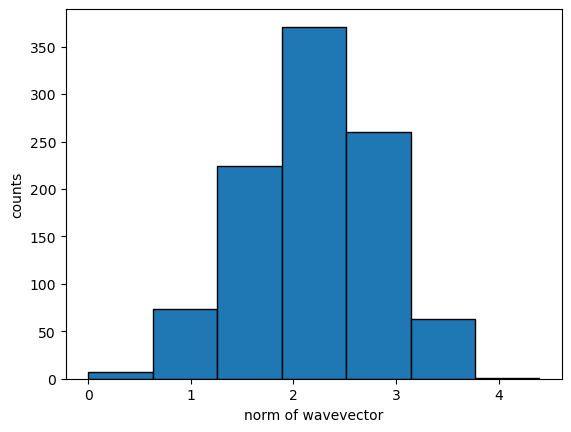

In [18]:
# Plot the histogram
plt.hist(k_norm.flatten(), k_bin_edges, edgecolor='black')
plt.xlabel('norm of wavevector')
plt.ylabel('counts')
plt.show()

Compute the binned Power spectrum averaging on circles in k-space, that is on cells where the norm of k is within a certain range

In [19]:
# Initialize arrays to store the bin values and the mean values of k_norm and Pk within each bin
k_bin = np.zeros(len(k_bin_edges) - 1)
pk_meas = np.zeros(len(k_bin_edges) - 1)

# Loop through each bin edge
for i in range(len(k_bin_edges)-1):
    # Find indices where the values of k_norm fall within the range defined by the bin edges
    indices_in_bin = np.where((k_norm.flatten() >= k_bin_edges[i]) & (k_norm.flatten() < k_bin_edges[i + 1]))[0]
    
    # Calculate the mean value of k_norm within the bin
    k_bin[i] = np.mean(k_norm.flatten()[indices_in_bin])
    
    # Calculate the mean value of Pk within the bin
    pk_meas[i] = np.mean(Pk.flatten()[indices_in_bin])


In [20]:
mask=[2*n for n in range(0, int(len(k_bin)/2))]
xticks=k_bin[mask]

[1.28571429e+03 1.41909681e-31 1.80311064e-33 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


([<matplotlib.axis.XTick at 0x148428760>,
 [Text(0.38571428571428573, 0, '0.386'),
  Text(1.5974788106984457, 0, '1.597'),
  Text(2.7687022912601633, 0, '2.769')])

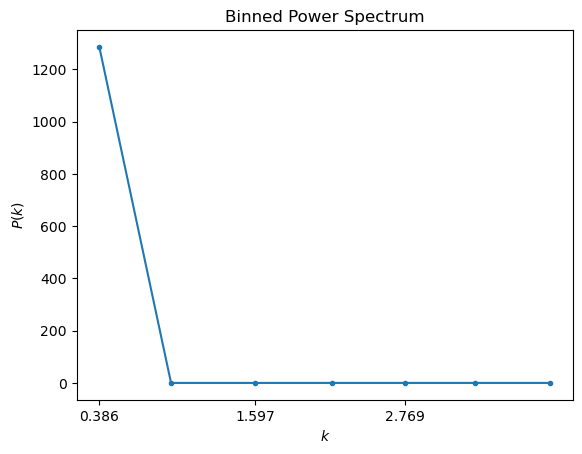

In [21]:
print(pk_meas)
plt.plot(k_bin,pk_meas, marker = '.')
plt.title('Binned Power Spectrum')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.xticks(xticks)

Note that instead of the previous code, one could use the following to find the indexes where the value of k_norm falls in a certain range

In [22]:
indices_in_bin = np.digitize(k_norm.flatten(), k_bin_edges)
pk_meas_v2 = np.zeros(len(k_bin_edges) - 1)
for i in range(len(indices_in_bin.flatten())):
    pk_meas_v2 [indices_in_bin[i]-1] += Pk.flatten()[i]

## not sure how to average, this way I'm just summing the values


In [23]:
print(pk_meas_v2)

[9.00000000e+03 1.05013164e-29 4.03896783e-31 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
